# load dataset

In [1]:
import glob
img_list = glob.glob("CHDS-1/*.png")
print(len(img_list))

18850


# test read image

In [2]:
from PIL import Image
print(img_list[0])
img_read = Image.open(img_list[0])
print(img_read)

CHDS-1\1(3)_３.png
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=57x57 at 0x204F26C2128>


In [3]:
print(img_read.size)

(57, 57)


In [4]:
print(img_read.mode)

RGB


In [5]:
out = img_read.resize((48, 48))

# construct data

In [138]:
import cv2
img_data = []
label_data = []
def import_data():
    for img in img_list:
        if img[-5] in ['ｐ', '＊', '≤', 'ｗ', '８', '｝', '３', 'ｘ', 'Ｉ', '）', 'ｑ', '［', 'ｎ', 'ｓ', '－', 'Ｈ', '？', 'ｇ', '６', 'ｄ', '７', 'Ｒ', 'Ｔ', '＋', 'Ｊ', 'Ｎ', 'Ｙ', '＝', '⊕','ｍ', '→', 'Ｅ', 'ｆ', 'ｋ', '２', '４', '÷','ｌ', 'ｂ', '９', 'ｙ', '↓', '←', '＜', 'ｉ', '５', 'Ｍ', 'Ｌ', 'ｅ', '１','Ｑ','＞', 'Ａ', 'Ｂ', 'Ｄ', 'Ｕ', 'ｕ', '（', 'Ｆ', 'ｔ', 'Ｇ', 'ｊ', '↑', '＃']: 
            img_read = Image.open(img)
            img_read = img_read.resize((48,48))
            img_data.append(img_read)
            label_data.append(img[-5])

In [139]:
import_data()

In [140]:
print(len(img_data), len(label_data))

11245 11245


In [141]:
label = list(set(label_data))

In [142]:
print(len(label))

64


# label to number

In [143]:
label2num = {l:i for i, l in enumerate(label)}

In [144]:
print(label2num)

{'↓': 0, '←': 1, 'Ｔ': 2, '≤': 3, '＊': 4, '＋': 5, 'ｐ': 6, '８': 7, 'ｗ': 8, '＜': 9, '｝': 10, 'Ｊ': 11, '３': 12, 'ｉ': 13, 'Ｎ': 14, 'Ａ': 15, 'Ｂ': 16, 'Ｙ': 17, 'ｘ': 18, '）': 19, 'Ｉ': 20, '５': 21, 'Ｄ': 22, '＝': 23, '⊕': 24, 'ｑ': 25, 'Ｕ': 26, 'ｌ': 27, 'ｍ': 28, '［': 29, '９': 30, 'ｕ': 31, '（': 32, 'ｎ': 33, 'Ｆ': 34, '→': 35, 'ｓ': 36, '－': 37, 'Ｅ': 38, 'ｔ': 39, 'Ｇ': 40, 'ｊ': 41, 'ｆ': 42, 'Ｈ': 43, 'Ｍ': 44, 'ｋ': 45, '？': 46, '２': 47, 'ｇ': 48, '４': 49, '６': 50, 'ｄ': 51, 'Ｌ': 52, 'ｅ': 53, '１': 54, '÷': 55, 'Ｑ': 56, '７': 57, 'Ｒ': 58, 'ｂ': 59, '＞': 60, '↑': 61, '＃': 62, 'ｙ': 63}


In [145]:
label_data_num = [label2num[l] for l in label_data]

In [146]:
print(len(label_data_num))

11245


In [147]:
num2label = {v:k for k, v in label2num.items()}

# convert to numarray

In [148]:
import numpy as np
x = np.array([np.array(img) for img in img_data])
y = np.array(label_data_num)

In [149]:
x.shape, y.shape

((11245, 48, 48, 3), (11245,))

# convert y to one-hot encoding

In [150]:
from keras.utils import to_categorical
y = to_categorical(y, 64)

In [151]:
y.shape

(11245, 64)

# train test split (split_ratio=0.3)

In [152]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [153]:
x_train.shape, x_test.shape

((7871, 48, 48, 3), (3374, 48, 48, 3))

# construct step_per_epoch

In [154]:
steps_train_epoch = x_train.shape[0] // 128
steps_test_epoch = x_test.shape[0] // 128

In [155]:
steps_train_epoch, steps_test_epoch

(61, 26)

# construct data generator: as data excludes GPU memory

In [25]:
def get_train_batch(X_train, y_train, batch_size):
    '''
    参数：
        X_train：所有图片路径列表
        y_train: 所有图片对应的标签列表
        batch_size:批次
        img_w:图片宽
        img_h:图片高
        color_type:图片类型
        is_argumentation:是否需要数据增强
    返回: 
        一个generator，x: 获取的批次图片 y: 获取的图片对应的标签
    '''
    while 1:
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            # 最重要的就是这个yield，它代表返回，返回以后循环还是会继续，然后再返回。就比如有一个机器一直在作累加运算，但是会把每次累加中间结果告诉你一样，直到把所有数加完
            yield x_batch, y_batch

# draw result

In [26]:
# draw result
import matplotlib.pyplot as plt
def draw_result(history, name):
    fig, ax = plt.subplots(2,1,figsize=(10,10))
    ax[0].plot(history.history['loss'], color='r', label='Training Loss')
    ax[0].plot(history.history['val_loss'], color='g', label='Validation Loss')
    ax[0].legend(loc='best',shadow=True)
    ax[0].grid(True)

    ax[1].plot(history.history['acc'], color='r', label='Training Accuracy')
    ax[1].plot(history.history['val_acc'], color='g', label='Validation Accuracy')
    ax[1].legend(loc='best',shadow=True)
    ax[1].grid(True)
    plt.savefig(name +".png")
    plt.show()

# data augmentation

In [27]:
from keras.preprocessing.image import ImageDataGenerator
data_augment = ImageDataGenerator(rotation_range= 10,zoom_range= 0.1,
                                  width_shift_range = 0.1,height_shift_range = 0.1,
                                  horizontal_flip = False, vertical_flip = False)

# change learning rate

In [28]:
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
# keras的callback类提供了可以跟踪目标值，和动态调整学习效率
# moitor : 要监测的量，这里是验证准确率
# matience: 当经过３轮的迭代，监测的目标量，仍没有变化，就会调整学习效率
# verbose : 信息展示模式，去０或１
# factor :　每次减少学习率的因子，学习率将以lr = lr*factor的形式被减少
# mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少。
# epsilon：阈值，用来确定是否进入检测值的“平原区”
# cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作
# min_lr：学习率的下限
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3,
                                            verbose = 1, factor=0.5, min_lr = 0.00001)

# evaluate

In [29]:
def evaluate(model, x, y):    
    loss, acc = model.evaluate(x, y)
    return loss, acc

# confusion matrix

In [59]:
from sklearn.metrics import confusion_matrix 
def get_confusion_mat(model, x, y):
    pred_y = model.predict(x)
    pred_label = np.argmax(pred_y, axis=1)
    true_label = np.argmax(y, axis=1)
    confusion_mat = confusion_matrix(true_label, pred_label)
    return confusion_mat

# compute per class's accuracy

In [66]:
from operator import truediv
def compute_per_acc(confusion_mat, num_label):
    list_diag = np.diag(confusion_mat)
    list_row_sum = np.sum(confusion_mat, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_row_sum))
    each_acc = list(each_acc)
    class2acc = list(zip(list(num_label.values()), each_acc))
    class2acc.sort(key=lambda item: item[1], reverse=True)
    return class2acc

# transfer learning using MobileNet

In [33]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception 
from keras.applications.inception_v3 import InceptionV3

from keras.models import Model
from keras.utils import multi_gpu_model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,BatchNormalization
from keras.optimizers import SGD,RMSprop,Adadelta
from keras.layers import Conv2D, MaxPooling2D,Flatten


#使用MobileNetV2网络模型进行训练
base_model = MobileNetV2(weights="imagenet", include_top=False,pooling = 'avg')
output = base_model.output
predictions = Dense(113, activation='softmax')(output)

model = Model(inputs=base_model.input, outputs=predictions)

C:\Users\lenovo\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [43]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

# train on double GPU for 50 epochs on 128 batch_size and adam optimizer

In [44]:
from keras.utils import multi_gpu_model
parallel_model = multi_gpu_model(model, gpus=2) # double GPU
parallel_model.compile(optimizer='adam' , loss='categorical_crossentropy', metrics=['accuracy'])
history = parallel_model.fit_generator(generator=get_train_batch(x_train, y_train, 128), steps_per_epoch=steps_train_epoch, 
          epochs=50,validation_data=get_train_batch(x_test, y_test, 128),          validation_steps=steps_test_epoch)

Epoch 1/50
103/103 [==============================] - 48s 468ms/step - loss: 3.3078 - acc: 0.2376 - val_loss: 2.3327 - val_acc: 0.4277
Epoch 2/50
103/103 [==============================] - 17s 169ms/step - loss: 1.3647 - acc: 0.5823 - val_loss: 1.6542 - val_acc: 0.5582
Epoch 3/50
103/103 [==============================] - 17s 166ms/step - loss: 0.9052 - acc: 0.7052 - val_loss: 2.3067 - val_acc: 0.5055
Epoch 4/50
103/103 [==============================] - 17s 164ms/step - loss: 0.6029 - acc: 0.7832 - val_loss: 1.5288 - val_acc: 0.6466
Epoch 5/50
103/103 [==============================] - 17s 165ms/step - loss: 0.5152 - acc: 0.8121 - val_loss: 1.4833 - val_acc: 0.6537
Epoch 6/50
103/103 [==============================] - 17s 163ms/step - loss: 0.4408 - acc: 0.8361 - val_loss: 1.6003 - val_acc: 0.6486
Epoch 7/50
103/103 [==============================] - 17s 166ms/step - loss: 0.4326 - acc: 0.8422 - val_loss: 1.2301 - val_acc: 0.7143
Epoch 8/50
103/103 [==============================] - 1

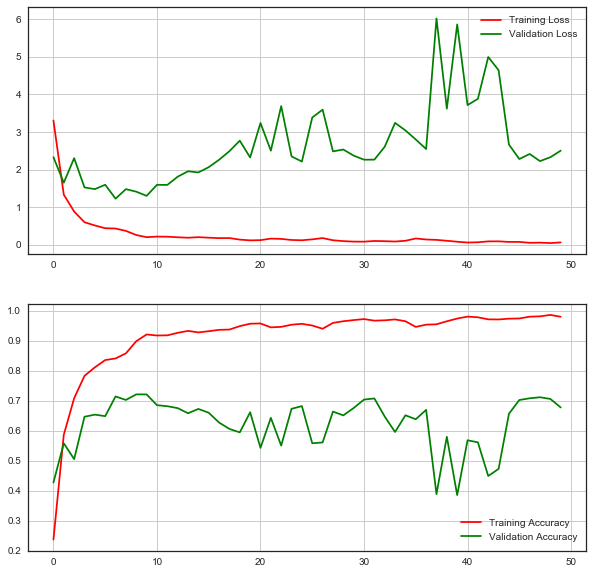

In [107]:
draw_result(history, "MobileNet")

In [127]:
loss, acc = evaluate(parallel_model, x, y)
print(loss, str(acc*100)+"%")

18850/18850 [==============================] - 40s 2ms/step
0.45520138877096294 94.17506631299734%


In [119]:
confusion_mat = get_confusion_mat(parallel_model, x, y)

In [123]:
per_acc = compute_per_acc(confusion_mat)

In [124]:
print(per_acc)

[('Ｂ', 1.0), ('≤', 1.0), ('＞', 1.0), ('Σ', 1.0), ('＝', 1.0), ('≠', 1.0), ('％', 1.0), ('－', 1.0), ('÷', 1.0), ('←', 1.0), ('Ｎ', 0.9948717948717949), ('ｔ', 0.9948717948717949), ('ｅ', 0.9948717948717949), ('Ｈ', 0.9948717948717949), ('λ', 0.9923076923076923), ('？', 0.9923076923076923), ('≥', 0.9923076923076923), ('＜', 0.9923076923076923), ('｛', 0.9923076923076923), ('γ', 0.9923076923076923), ('τ', 0.9923076923076923), ('Ａ', 0.9897435897435898), ('Ｙ', 0.9897435897435898), ('ｄ', 0.9897435897435898), ('Ｌ', 0.9897435897435898), ('ｈ', 0.9897435897435898), ('＠', 0.9846153846153847), ('↑', 0.9846153846153847), ('＃', 0.9846153846153847), ('ｂ', 0.9846153846153847), ('５', 0.9846153846153847), ('↓', 0.9846153846153847), ('］', 0.9846153846153847), ('３', 0.9846153846153847), ('Ｄ', 0.9846153846153847), ('Ω', 0.9846153846153847), ('θ', 0.9846153846153847), ('＄', 0.9846153846153847), ('Ｅ', 0.9794871794871794), ('Ｆ', 0.9794871794871794), ('Ｔ', 0.9794871794871794), ('８', 0.9794871794871794), ('Ｒ', 0.9794871

# train on adam with momentum

In [48]:
ADAM=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
parallel_model_1 = multi_gpu_model(model, gpus=2) # double GPU
parallel_model_1.compile(optimizer=ADAM , loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = parallel_model_1.fit_generator(generator=get_train_batch(x_train, y_train, 128), steps_per_epoch=steps_train_epoch, 
          epochs=10,validation_data=get_train_batch(x_test, y_test, 128),          validation_steps=steps_test_epoch)draw_result(history, "MobileNet"

Epoch 1/10
103/103 [==============================] - 48s 466ms/step - loss: 0.1296 - acc: 0.9601 - val_loss: 1.2657 - val_acc: 0.7520
Epoch 2/10
103/103 [==============================] - 17s 164ms/step - loss: 0.1080 - acc: 0.9653 - val_loss: 1.2116 - val_acc: 0.7668
Epoch 3/10
103/103 [==============================] - 17s 166ms/step - loss: 0.1115 - acc: 0.9672 - val_loss: 1.4938 - val_acc: 0.7400
Epoch 4/10
103/103 [==============================] - 17s 167ms/step - loss: 0.1517 - acc: 0.9550 - val_loss: 1.8500 - val_acc: 0.7215
Epoch 5/10
103/103 [==============================] - 17s 167ms/step - loss: 0.1039 - acc: 0.9691 - val_loss: 1.8596 - val_acc: 0.7424
Epoch 6/10
103/103 [==============================] - 17s 166ms/step - loss: 0.0818 - acc: 0.9755 - val_loss: 1.5727 - val_acc: 0.7480
Epoch 7/10
103/103 [==============================] - 17s 167ms/step - loss: 0.0676 - acc: 0.9801 - val_loss: 1.5876 - val_acc: 0.7642
Epoch 8/10
103/103 [==============================] - 1

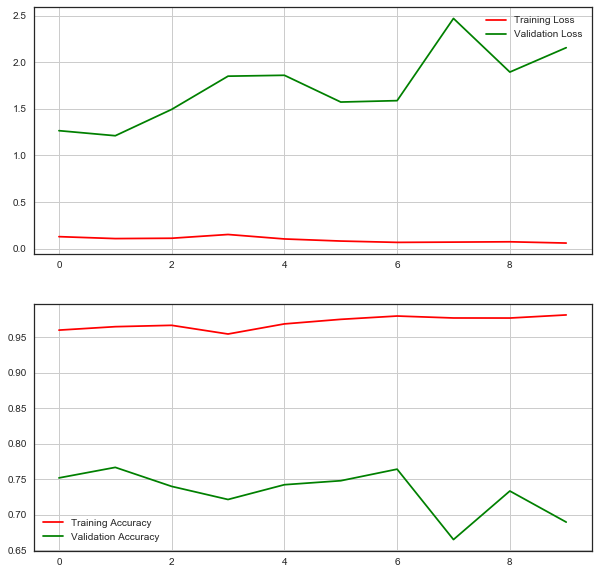

In [110]:
draw_result(history_1, "MobileNet1")

# MobileNet training with learning rate decay

In [114]:
from keras.utils import multi_gpu_model
optimizer = RMSprop(lr = 0.001, decay=0.0)
parallel_model_2 = multi_gpu_model(model, gpus=2) # double GPU
parallel_model_2.compile(optimizer=optimizer , loss='categorical_crossentropy', metrics=['accuracy'])
history = parallel_model_2.fit_generator(generator=get_train_batch(x_train, y_train, 128), steps_per_epoch=steps_train_epoch, 
          epochs=50,validation_data=get_train_batch(x_test, y_test, 128),validation_steps=steps_test_epoch, callbacks=[learning_rate_reduction])

Epoch 1/50
103/103 [==============================] - 51s 492ms/step - loss: 0.0919 - acc: 0.9727 - val_loss: 1.0571 - val_acc: 0.7839
Epoch 2/50
103/103 [==============================] - 17s 168ms/step - loss: 0.0699 - acc: 0.9798 - val_loss: 1.2270 - val_acc: 0.7737
Epoch 3/50
103/103 [==============================] - 17s 169ms/step - loss: 0.0704 - acc: 0.9781 - val_loss: 1.3516 - val_acc: 0.7650
Epoch 4/50
103/103 [==============================] - 17s 166ms/step - loss: 0.0671 - acc: 0.9813 - val_loss: 1.4652 - val_acc: 0.7501

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
103/103 [==============================] - 17s 166ms/step - loss: 0.0198 - acc: 0.9936 - val_loss: 1.1456 - val_acc: 0.7925
Epoch 6/50
103/103 [==============================] - 17s 165ms/step - loss: 0.0113 - acc: 0.9962 - val_loss: 1.1824 - val_acc: 0.8037
Epoch 7/50
103/103 [==============================] - 17s 165ms/step - loss: 0.0122 - acc: 0.9966 - val_loss:

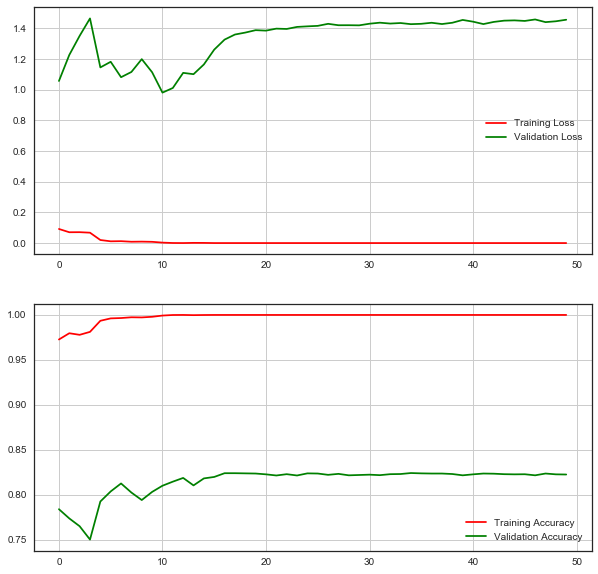

In [115]:
draw_result(history, "MobileNet2")

In [129]:
loss_2, acc_2 = evaluate(parallel_model_2, x, y)
print(loss, str(acc*100)+"%")

18850/18850 [==============================] - 40s 2ms/step
0.45520138877096294 94.17506631299734%


In [125]:
confusion_mat2 = get_confusion_mat(parallel_model_2, x, y)

In [128]:
per_acc_2 = compute_per_acc(confusion_mat2)
print(per_acc_2)

[('Ｂ', 1.0), ('≤', 1.0), ('＞', 1.0), ('Σ', 1.0), ('＝', 1.0), ('≠', 1.0), ('％', 1.0), ('－', 1.0), ('÷', 1.0), ('←', 1.0), ('Ｎ', 0.9948717948717949), ('ｔ', 0.9948717948717949), ('ｅ', 0.9948717948717949), ('Ｈ', 0.9948717948717949), ('λ', 0.9923076923076923), ('？', 0.9923076923076923), ('≥', 0.9923076923076923), ('＜', 0.9923076923076923), ('｛', 0.9923076923076923), ('γ', 0.9923076923076923), ('τ', 0.9923076923076923), ('Ａ', 0.9897435897435898), ('Ｙ', 0.9897435897435898), ('ｄ', 0.9897435897435898), ('Ｌ', 0.9897435897435898), ('ｈ', 0.9897435897435898), ('＠', 0.9846153846153847), ('↑', 0.9846153846153847), ('＃', 0.9846153846153847), ('ｂ', 0.9846153846153847), ('５', 0.9846153846153847), ('↓', 0.9846153846153847), ('］', 0.9846153846153847), ('３', 0.9846153846153847), ('Ｄ', 0.9846153846153847), ('Ω', 0.9846153846153847), ('θ', 0.9846153846153847), ('＄', 0.9846153846153847), ('Ｅ', 0.9794871794871794), ('Ｆ', 0.9794871794871794), ('Ｔ', 0.9794871794871794), ('８', 0.9794871794871794), ('Ｒ', 0.9794871

# CNN_SENet 

In [101]:
import keras
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Convolution2D, Permute, Reshape, multiply, add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
import keras.backend as K
from keras.callbacks import ModelCheckpoint
import os
import matplotlib.pyplot as plt

c = 53
# se-block
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = int(init.shape[-1])
    se_shape = (1, 1, filters)
    res = int(filters // ratio)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(res, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)


    x = multiply([init, se])
    return x

# input
input_data = Input(shape=[48, 48, 3])
# first layer
conv1 = Convolution2D(filters=32, kernel_size=[3, 3])(input_data)
BN1 = BatchNormalization()(conv1)
se1 = squeeze_excite_block(BN1)
ac1 = Activation('relu')(se1)
pool1 = MaxPooling2D(pool_size=[2, 2], strides=[2, 2])(ac1)

# second layer
conv2 = Convolution2D(filters=64, kernel_size=[3, 3])(pool1)
BN2 = BatchNormalization()(conv2)
se2 = squeeze_excite_block(BN2)
ac2 = Activation('relu')(se2)

# third layer
conv3 = Convolution2D(filters=64, kernel_size=[3, 3])(ac2)
BN3 = BatchNormalization()(conv3)
se3 = squeeze_excite_block(BN3)
ac3 = Activation('relu')(se3)
pool3 = MaxPooling2D(pool_size=[2, 2], strides=[2, 2])(ac3)

# forth layer
conv4 = Convolution2D(filters=128, kernel_size=[2, 2])(pool3)
BN4 = BatchNormalization()(conv4)
se4 = squeeze_excite_block(BN4)
ac4 = Activation('relu')(se4)
pool4 = MaxPooling2D(pool_size=[2, 2], strides=[2, 2])(ac4)

# fifth layer
conv5 = Convolution2D(filters=256, kernel_size=[2, 2])(pool4)
BN5 = BatchNormalization()(conv5)
se5 = squeeze_excite_block(BN5)
ac5 = Activation('relu')(se5)
pool5 = MaxPooling2D(pool_size=[2, 2], strides=[2, 2])(ac5)

# flatten
flatten = Flatten()(pool5)

# fc1
fc1 = Dense(units=256)(flatten)
fc_bn1 = BatchNormalization()(fc1)
fc_ac1 = Activation('relu')(fc_bn1)

# fc2
fc2 = Dense(units=128)(fc_ac1)
fc_bn2 = BatchNormalization()(fc2)
fc_ac2 = Activation('relu')(fc_bn2)
dp = Dropout(0.5)(fc_ac2)

# fc3
fc3 = Dense(units=113)(dp)
fc_bn3 = BatchNormalization()(fc3)
output = Activation('softmax')(fc_bn3)

se_model = Model(inputs=input_data, outputs=output)

# compile model
se_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
se_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 32)           0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
reshape_1 

In [104]:
se_history = se_model.fit_generator(generator=get_train_batch(x_train, y_train, 128), steps_per_epoch=steps_train_epoch, 
          epochs=50,validation_data=get_train_batch(x_test, y_test, 128),          validation_steps=steps_test_epoch)

Epoch 1/50
103/103 [==============================] - 5s 45ms/step - loss: 0.8467 - acc: 0.8078 - val_loss: 2.0900 - val_acc: 0.4806
Epoch 2/50
103/103 [==============================] - 5s 45ms/step - loss: 0.7849 - acc: 0.8225 - val_loss: 1.4411 - val_acc: 0.6345
Epoch 3/50
103/103 [==============================] - 5s 45ms/step - loss: 0.7324 - acc: 0.8369 - val_loss: 1.0695 - val_acc: 0.7187
Epoch 4/50
103/103 [==============================] - 5s 46ms/step - loss: 0.6803 - acc: 0.8483 - val_loss: 1.1442 - val_acc: 0.7011
Epoch 5/50
103/103 [==============================] - 5s 46ms/step - loss: 0.6247 - acc: 0.8638 - val_loss: 0.8646 - val_acc: 0.7579
Epoch 6/50
103/103 [==============================] - 5s 46ms/step - loss: 0.5894 - acc: 0.8688 - val_loss: 0.9579 - val_acc: 0.7315
Epoch 7/50
103/103 [==============================] - 5s 45ms/step - loss: 0.5516 - acc: 0.8786 - val_loss: 0.9082 - val_acc: 0.7456
Epoch 8/50
103/103 [==============================] - 5s 45ms/step - 

In [130]:
from keras.utils import multi_gpu_model
optimizer = RMSprop(lr = 0.001, decay=0.0)
parallel_model_se = multi_gpu_model(se_model, gpus=2) # double GPU
parallel_model_se.compile(optimizer=optimizer , loss='categorical_crossentropy', metrics=['accuracy'])
history_se = parallel_model_se.fit_generator(generator=get_train_batch(x_train, y_train, 128), steps_per_epoch=steps_train_epoch, 
          epochs=50,validation_data=get_train_batch(x_test, y_test, 128),validation_steps=steps_test_epoch, callbacks=[learning_rate_reduction])

Epoch 1/50
103/103 [==============================] - 54s 521ms/step - loss: 1.2529e-07 - acc: 1.0000 - val_loss: 1.4821 - val_acc: 0.8249
Epoch 2/50
103/103 [==============================] - 17s 167ms/step - loss: 1.2140e-07 - acc: 1.0000 - val_loss: 1.4861 - val_acc: 0.8223
Epoch 3/50
103/103 [==============================] - 18s 170ms/step - loss: 1.2006e-07 - acc: 1.0000 - val_loss: 1.4704 - val_acc: 0.8231
Epoch 4/50
103/103 [==============================] - 17s 169ms/step - loss: 1.1964e-07 - acc: 1.0000 - val_loss: 1.4776 - val_acc: 0.8232

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
103/103 [==============================] - 18s 170ms/step - loss: 1.1945e-07 - acc: 1.0000 - val_loss: 1.4879 - val_acc: 0.8236
Epoch 6/50
103/103 [==============================] - 18s 170ms/step - loss: 1.1939e-07 - acc: 1.0000 - val_loss: 1.4878 - val_acc: 0.8238
Epoch 7/50
103/103 [==============================] - 17s 169ms/step - loss: 1.1935e-

# 合并符号

In [32]:
print(label)

['ｐ', '≤', '＊', 'ｗ', '８', 'ｖ', '｝', 'λ', '３', 'ｘ', '）', 'Ｉ', 'μ', 'ｑ', '０', '［', 'ｎ', 'ｓ', '－', 'ρ', 'Ｃ', 'Ｈ', '？', 'ｇ', '６', 'ｄ', '｛', 'π', 'Ｖ', '７', '≥', 'Ｒ', '＆', 'ψ', 'β', 'Ｔ', '＋', '％', 'Ｊ', 'Ψ', 'Ｎ', 'Ｙ', '＝', '⊕', 'ａ', 'ｍ', '→', '≠', 'Π', 'Φ', 'Ｅ', 'ｆ', 'ｋ', '２', '４', 'Ｘ', '÷', 'Ω', 'Ｏ', 'ｂ', 'ｌ', 'φ', '９', 'ｙ', '↓', '←', '＜', 'ｉ', 'δ', 'η', '￥', 'γ', 'Ｐ', '５', 'ε', 'ｏ', 'Ｋ', 'ｈ', 'ｃ', 'ζ', 'Ｍ', 'σ', 'Ｌ', 'ｅ', '１', 'α', 'Ｑ', 'ｚ', '＞', 'ｒ', 'θ', 'Ａ', 'Ｂ', '＄', 'Ｄ', '］', 'Ｕ', 'Ｚ', 'Ｓ', 'Ｗ', 'ｕ', '（', 'Ｆ', 'τ', 'ｔ', 'Ｇ', 'ｊ', 'ω', 'Σ', '＠', 'ξ', '↑', '＃']


In [33]:
print(label2num)

{'ｐ': 0, '≤': 1, '＊': 2, 'ｗ': 3, '８': 4, 'ｖ': 5, '｝': 6, 'λ': 7, '３': 8, 'ｘ': 9, '）': 10, 'Ｉ': 11, 'μ': 12, 'ｑ': 13, '０': 14, '［': 15, 'ｎ': 16, 'ｓ': 17, '－': 18, 'ρ': 19, 'Ｃ': 20, 'Ｈ': 21, '？': 22, 'ｇ': 23, '６': 24, 'ｄ': 25, '｛': 26, 'π': 27, 'Ｖ': 28, '７': 29, '≥': 30, 'Ｒ': 31, '＆': 32, 'ψ': 33, 'β': 34, 'Ｔ': 35, '＋': 36, '％': 37, 'Ｊ': 38, 'Ψ': 39, 'Ｎ': 40, 'Ｙ': 41, '＝': 42, '⊕': 43, 'ａ': 44, 'ｍ': 45, '→': 46, '≠': 47, 'Π': 48, 'Φ': 49, 'Ｅ': 50, 'ｆ': 51, 'ｋ': 52, '２': 53, '４': 54, 'Ｘ': 55, '÷': 56, 'Ω': 57, 'Ｏ': 58, 'ｂ': 59, 'ｌ': 60, 'φ': 61, '９': 62, 'ｙ': 63, '↓': 64, '←': 65, '＜': 66, 'ｉ': 67, 'δ': 68, 'η': 69, '￥': 70, 'γ': 71, 'Ｐ': 72, '５': 73, 'ε': 74, 'ｏ': 75, 'Ｋ': 76, 'ｈ': 77, 'ｃ': 78, 'ζ': 79, 'Ｍ': 80, 'σ': 81, 'Ｌ': 82, 'ｅ': 83, '１': 84, 'α': 85, 'Ｑ': 86, 'ｚ': 87, '＞': 88, 'ｒ': 89, 'θ': 90, 'Ａ': 91, 'Ｂ': 92, '＄': 93, 'Ｄ': 94, '］': 95, 'Ｕ': 96, 'Ｚ': 97, 'Ｓ': 98, 'Ｗ': 99, 'ｕ': 100, '（': 101, 'Ｆ': 102, 'τ': 103, 'ｔ': 104, 'Ｇ': 105, 'ｊ': 106, 'ω': 107, 'Σ': 108, '＠': 109, 'ξ': 110,

In [34]:
print(len(label_data))

18850


In [35]:
if 'Ｃ' in label:
    print('C')

C


In [36]:
label2 = label[:]
for i in range(len(label)):
    if label[i]=='Ｃ':
        label2[i]='ｃ'
        print('c')
    if label[i]=='Ｏ':
        label2[i]= 'ｏ'
        print('o')
    if label[i]=='Ｓ':
        label2[i]='ｓ'
        print('s')
    if label[i]=='Ｖ':
        label2[i]= 'ｖ'
        print('v')
    if label[i]=='Ｗ':
        label2[i]= 'ｗ'
        print('w')
    if label[i]=='Ｋ':
        label2[i]='ｋ'
        print('k')
    if label[i]=='Ｐ':
        label2[i]='ｐ'
        print('p')
    if label[i]=='Ｘ':
        label2[i]='ｘ'
        print('x')
    if label[i]=='Ｚ':
        label2[i]= 'ｚ'
        print('z')

c
v
x
o
p
k
z
s
w


In [37]:
label_2 = list(set(label2))

In [38]:
len(label_2), len(label)

(104, 113)

In [39]:
print(label_2)

['ｐ', '＊', '≤', 'ｗ', '８', 'ｖ', '｝', 'λ', '３', 'ｘ', 'Ｉ', '）', 'μ', 'ｑ', '０', '［', 'ｎ', 'ｓ', '－', 'ρ', 'Ｈ', '？', 'ｇ', '６', 'ｄ', '｛', 'π', '７', '≥', 'Ｒ', '＆', 'ψ', 'β', 'Ｔ', '＋', '％', 'Ｊ', 'Ψ', 'Ｎ', 'Ｙ', '＝', '⊕', 'ａ', 'ｍ', '→', '≠', 'Π', 'Φ', 'Ｅ', 'ｆ', 'ｋ', '２', '４', '÷', 'Ω', 'ｌ', 'ｂ', 'φ', '９', 'ｙ', '↓', '←', '＜', 'ｉ', 'δ', 'η', '￥', 'γ', '５', 'ε', 'ｏ', 'ｈ', 'ｃ', 'ζ', 'Ｍ', 'σ', 'Ｌ', 'ｅ', '１', 'α', 'Ｑ', 'ｚ', '＞', 'ｒ', 'θ', 'Ａ', 'Ｂ', '＄', 'Ｄ', '］', 'Ｕ', 'ｕ', '（', 'Ｆ', 'τ', 'ｔ', 'Ｇ', 'ｊ', 'ω', 'Σ', '＠', 'ξ', '↑', '＃']


In [63]:
label2num_2 = {l:i for i, l in enumerate(label_2)}

In [64]:
label2num_2

{'ｐ': 0,
 '＊': 1,
 '≤': 2,
 'ｗ': 3,
 '８': 4,
 'ｖ': 5,
 '｝': 6,
 'λ': 7,
 '３': 8,
 'ｘ': 9,
 'Ｉ': 10,
 '）': 11,
 'μ': 12,
 'ｑ': 13,
 '０': 14,
 '［': 15,
 'ｎ': 16,
 'ｓ': 17,
 '－': 18,
 'ρ': 19,
 'Ｈ': 20,
 '？': 21,
 'ｇ': 22,
 '６': 23,
 'ｄ': 24,
 '｛': 25,
 'π': 26,
 '７': 27,
 '≥': 28,
 'Ｒ': 29,
 '＆': 30,
 'ψ': 31,
 'β': 32,
 'Ｔ': 33,
 '＋': 34,
 '％': 35,
 'Ｊ': 36,
 'Ψ': 37,
 'Ｎ': 38,
 'Ｙ': 39,
 '＝': 40,
 '⊕': 41,
 'ａ': 42,
 'ｍ': 43,
 '→': 44,
 '≠': 45,
 'Π': 46,
 'Φ': 47,
 'Ｅ': 48,
 'ｆ': 49,
 'ｋ': 50,
 '２': 51,
 '４': 52,
 '÷': 53,
 'Ω': 54,
 'ｌ': 55,
 'ｂ': 56,
 'φ': 57,
 '９': 58,
 'ｙ': 59,
 '↓': 60,
 '←': 61,
 '＜': 62,
 'ｉ': 63,
 'δ': 64,
 'η': 65,
 '￥': 66,
 'γ': 67,
 '５': 68,
 'ε': 69,
 'ｏ': 70,
 'ｈ': 71,
 'ｃ': 72,
 'ζ': 73,
 'Ｍ': 74,
 'σ': 75,
 'Ｌ': 76,
 'ｅ': 77,
 '１': 78,
 'α': 79,
 'Ｑ': 80,
 'ｚ': 81,
 '＞': 82,
 'ｒ': 83,
 'θ': 84,
 'Ａ': 85,
 'Ｂ': 86,
 '＄': 87,
 'Ｄ': 88,
 '］': 89,
 'Ｕ': 90,
 'ｕ': 91,
 '（': 92,
 'Ｆ': 93,
 'τ': 94,
 'ｔ': 95,
 'Ｇ': 96,
 'ｊ': 97,
 'ω': 98,
 'Σ': 99,
 '＠': 100,

In [42]:
label_data_2 = label_data[:]
for i in range(len(label_data)):
    if label_data[i]=='Ｃ':
        label_data_2[i]='ｃ'
        print('c')
    if label_data[i]=='Ｏ':
        label_data_2[i]= 'ｏ'
        print('o')
    if label_data[i]=='Ｓ':
        label_data_2[i]='ｓ'
        print('s')
    if label_data[i]=='Ｖ':
        label_data_2[i]= 'ｖ'
        print('v')
    if label_data[i]=='Ｗ':
        label_data_2[i]= 'ｗ'
        print('w')
    if label_data[i]=='Ｋ':
        label_data_2[i]='ｋ'
        print('k')
    if label_data[i]=='Ｐ':
        label_data_2[i]='ｐ'
        print('p')
    if label_data[i]=='Ｘ':
        label_data_2[i]='ｘ'
        print('x')
    if label_data[i]=='Ｚ':
        label_data_2[i]= 'ｚ'
        print('z')

c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
c
k
p
v
w
x
o
s
z
c
k
p
v
w
x
o
s


In [43]:
label_data_num_2 = [label2num_2[l] for l in label_data_2]

In [65]:
len(label_data_num_2)

18850

In [67]:
num_label_2 = {v:k for k, v in label2num_2.items()}

In [68]:
num_label_2

{0: 'ｐ',
 1: '＊',
 2: '≤',
 3: 'ｗ',
 4: '８',
 5: 'ｖ',
 6: '｝',
 7: 'λ',
 8: '３',
 9: 'ｘ',
 10: 'Ｉ',
 11: '）',
 12: 'μ',
 13: 'ｑ',
 14: '０',
 15: '［',
 16: 'ｎ',
 17: 'ｓ',
 18: '－',
 19: 'ρ',
 20: 'Ｈ',
 21: '？',
 22: 'ｇ',
 23: '６',
 24: 'ｄ',
 25: '｛',
 26: 'π',
 27: '７',
 28: '≥',
 29: 'Ｒ',
 30: '＆',
 31: 'ψ',
 32: 'β',
 33: 'Ｔ',
 34: '＋',
 35: '％',
 36: 'Ｊ',
 37: 'Ψ',
 38: 'Ｎ',
 39: 'Ｙ',
 40: '＝',
 41: '⊕',
 42: 'ａ',
 43: 'ｍ',
 44: '→',
 45: '≠',
 46: 'Π',
 47: 'Φ',
 48: 'Ｅ',
 49: 'ｆ',
 50: 'ｋ',
 51: '２',
 52: '４',
 53: '÷',
 54: 'Ω',
 55: 'ｌ',
 56: 'ｂ',
 57: 'φ',
 58: '９',
 59: 'ｙ',
 60: '↓',
 61: '←',
 62: '＜',
 63: 'ｉ',
 64: 'δ',
 65: 'η',
 66: '￥',
 67: 'γ',
 68: '５',
 69: 'ε',
 70: 'ｏ',
 71: 'ｈ',
 72: 'ｃ',
 73: 'ζ',
 74: 'Ｍ',
 75: 'σ',
 76: 'Ｌ',
 77: 'ｅ',
 78: '１',
 79: 'α',
 80: 'Ｑ',
 81: 'ｚ',
 82: '＞',
 83: 'ｒ',
 84: 'θ',
 85: 'Ａ',
 86: 'Ｂ',
 87: '＄',
 88: 'Ｄ',
 89: '］',
 90: 'Ｕ',
 91: 'ｕ',
 92: '（',
 93: 'Ｆ',
 94: 'τ',
 95: 'ｔ',
 96: 'Ｇ',
 97: 'ｊ',
 98: 'ω',
 99: 'Σ',
 100: '＠',

In [45]:
y_2 = np.array(label_data_num_2)
from keras.utils import to_categorical
y_2 = to_categorical(y_2, 104)

In [46]:
y_2.shape

(18850, 104)

In [47]:
from sklearn.model_selection import train_test_split
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y_2, test_size=0.3, random_state=0)

In [48]:
x_train_2.shape, x_test_2.shape

((13195, 48, 48, 3), (5655, 48, 48, 3))

In [49]:
y_train_2.shape, y_test_2.shape

((13195, 104), (5655, 104))

In [51]:
import keras
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Convolution2D, Permute, Reshape, multiply, add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
import keras.backend as K
from keras.callbacks import ModelCheckpoint
import os
import matplotlib.pyplot as plt

c = 104
# se-block
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = int(init.shape[-1])
    se_shape = (1, 1, filters)
    res = int(filters // ratio)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(res, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)


    x = multiply([init, se])
    return x

# input
input_data = Input(shape=[48, 48, 3])
# first layer
conv1 = Convolution2D(filters=32, kernel_size=[2, 2])(input_data)
BN1 = BatchNormalization()(conv1)
se1 = squeeze_excite_block(BN1)
ac1 = Activation('relu')(se1)
pool1 = MaxPooling2D(pool_size=[2, 2], strides=[1, 1])(ac1)


# third layer
conv3 = Convolution2D(filters=64, kernel_size=[2, 2])(pool1)
BN3 = BatchNormalization()(conv3)
se3 = squeeze_excite_block(BN3)
ac3 = Activation('relu')(se3)
pool3 = MaxPooling2D(pool_size=[2, 2], strides=[1, 1])(ac3)

# forth layer
conv4 = Convolution2D(filters=128, kernel_size=[2, 2])(pool3)
BN4 = BatchNormalization()(conv4)
se4 = squeeze_excite_block(BN4)
ac4 = Activation('relu')(se4)
pool4 = MaxPooling2D(pool_size=[2, 2], strides=[1, 1])(ac4)

# fifth layer
conv5 = Convolution2D(filters=256, kernel_size=[2, 2])(pool4)
BN5 = BatchNormalization()(conv5)
se5 = squeeze_excite_block(BN5)
ac5 = Activation('relu')(se5)
pool5 = MaxPooling2D(pool_size=[2, 2], strides=[2, 2])(ac5)

# flatten
flatten = Flatten()(pool5)

# fc1
fc1 = Dense(units=1024)(flatten)
fc_bn1 = BatchNormalization()(fc1)
fc_ac1 = Activation('relu')(fc_bn1)

# fc2
fc2 = Dense(units=128)(fc_ac1)
fc_bn2 = BatchNormalization()(fc2)
fc_ac2 = Activation('relu')(fc_bn2)
dp = Dropout(0.5)(fc_ac2)

# fc3
fc3 = Dense(units=104)(dp)
fc_bn3 = BatchNormalization()(fc3)
output = Activation('softmax')(fc_bn3)

se_model_2 = Model(inputs=input_data, outputs=output)

se_model_2.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 47, 47, 32)   416         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 47, 47, 32)   128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 32)           0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
reshape_5 

In [52]:
optimizer = RMSprop(lr = 0.001, decay=0.0)
se_model_2.compile(optimizer=optimizer , loss='categorical_crossentropy', metrics=['accuracy'])
history_se_2 = se_model_2.fit_generator(generator=get_train_batch(x_train_2, y_train_2, 128), steps_per_epoch=steps_train_epoch, 
          epochs=50,validation_data=get_train_batch(x_test_2, y_test_2, 128),validation_steps=steps_test_epoch, callbacks=[learning_rate_reduction])

Epoch 1/50
103/103 [==============================] - 28s 268ms/step - loss: 3.0400 - acc: 0.3844 - val_loss: 1.9233 - val_acc: 0.6088
Epoch 2/50
103/103 [==============================] - 19s 182ms/step - loss: 1.9329 - acc: 0.6808 - val_loss: 1.8033 - val_acc: 0.6651
Epoch 3/50
103/103 [==============================] - 19s 185ms/step - loss: 1.4016 - acc: 0.7986 - val_loss: 1.6253 - val_acc: 0.7851
Epoch 4/50
103/103 [==============================] - 19s 184ms/step - loss: 1.0525 - acc: 0.8798 - val_loss: 1.7520 - val_acc: 0.7849
Epoch 5/50
103/103 [==============================] - 19s 184ms/step - loss: 0.8016 - acc: 0.9271 - val_loss: 1.2857 - val_acc: 0.8182
Epoch 6/50
103/103 [==============================] - 19s 183ms/step - loss: 0.6436 - acc: 0.9525 - val_loss: 1.2700 - val_acc: 0.8097
Epoch 7/50
103/103 [==============================] - 19s 180ms/step - loss: 0.5182 - acc: 0.9662 - val_loss: 1.2367 - val_acc: 0.8120
Epoch 8/50
103/103 [==============================] - 1

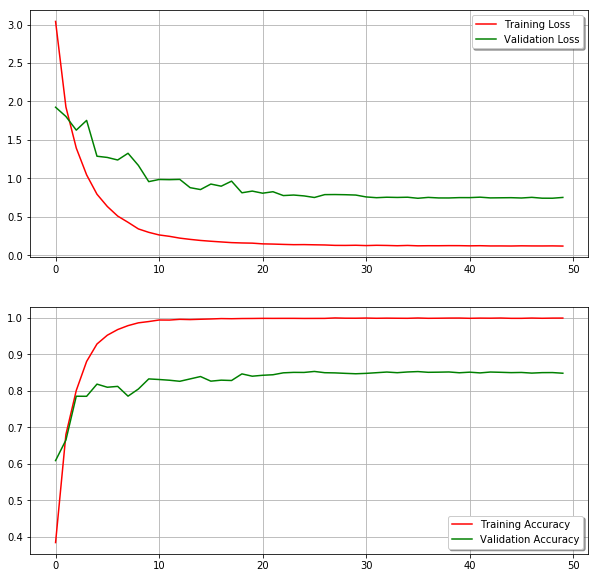

In [53]:
draw_result(history_se_2, "CNN_SENet+case")

In [56]:
loss_case, acc_case = evaluate(se_model_2, x, y_2)
print(loss_case, str(acc_case*100)+"%")

18850/18850 [==============================] - 8s 427us/step
0.2307035762047894 95.47480106100795%


In [70]:
loss_case_test, acc_case_test = evaluate(se_model_2, x_test_2, y_test_2)
print(loss_case_test, str(acc_case_test*100)+"%")

5655/5655 [==============================] - 2s 404us/step
0.7454399429149695 84.91600354090926%


In [69]:
confusion_mat_case = get_confusion_mat(se_model_2, x, y_2)
per_acc_case = compute_per_acc(confusion_mat_case, num_label_2)
print(per_acc_case)

[('←', 1.0), ('Ｂ', 1.0), ('Ｌ', 0.9948717948717949), ('Ａ', 0.9948717948717949), ('≤', 0.9923076923076923), ('－', 0.9923076923076923), ('？', 0.9923076923076923), ('Ω', 0.9923076923076923), ('Σ', 0.9923076923076923), ('Ｈ', 0.9897435897435898), ('ｄ', 0.9897435897435898), ('ｃ', 0.9871794871794872), ('ｗ', 0.9846153846153847), ('≥', 0.9846153846153847), ('％', 0.9846153846153847), ('Ｎ', 0.9846153846153847), ('Ｙ', 0.9846153846153847), ('＝', 0.9846153846153847), ('≠', 0.9846153846153847), ('ｋ', 0.9846153846153847), ('↓', 0.9846153846153847), ('ｅ', 0.9846153846153847), ('Ｆ', 0.9846153846153847), ('＠', 0.9846153846153847), ('↑', 0.9846153846153847), ('＃', 0.9846153846153847), ('Ｅ', 0.9794871794871794), ('ｉ', 0.9794871794871794), ('ｐ', 0.9769230769230769), ('ｓ', 0.9769230769230769), ('÷', 0.9769230769230769), ('＞', 0.9769230769230769), ('ｘ', 0.9743589743589743), ('ｂ', 0.9743589743589743), ('９', 0.9743589743589743), ('￥', 0.9730769230769231), ('ｖ', 0.9717948717948718), ('＊', 0.9692307692307692), ('λ

In [71]:
confusion_mat_case_test = get_confusion_mat(se_model_2, x_test_2, y_test_2)
per_acc_case_test = compute_per_acc(confusion_mat_case_test, num_label_2)
print(per_acc_case_test)

[('←', 1.0), ('Ｂ', 1.0), ('Ｌ', 0.9827586206896551), ('Ａ', 0.98), ('Σ', 0.9782608695652174), ('≤', 0.9761904761904762), ('Ω', 0.975609756097561), ('ｄ', 0.9714285714285714), ('－', 0.96875), ('？', 0.967741935483871), ('Ｈ', 0.9622641509433962), ('ｃ', 0.959349593495935), ('≥', 0.9555555555555556), ('≠', 0.9545454545454546), ('＃', 0.9545454545454546), ('％', 0.9534883720930233), ('ｅ', 0.953125), ('ｋ', 0.95), ('ｗ', 0.9495798319327731), ('↑', 0.9473684210526315), ('Ｎ', 0.9433962264150944), ('Ｆ', 0.9433962264150944), ('＠', 0.9428571428571428), ('Ｙ', 0.9423076923076923), ('＝', 0.9393939393939394), ('Ｅ', 0.9375), ('↓', 0.9285714285714286), ('÷', 0.926829268292683), ('ｓ', 0.9262295081967213), ('ｘ', 0.9212598425196851), ('ｉ', 0.92), ('ｐ', 0.9196428571428571), ('→', 0.9166666666666666), ('ｂ', 0.9152542372881356), ('＞', 0.9142857142857143), ('Π', 0.9090909090909091), ('４', 0.9090909090909091), ('｛', 0.9069767441860465), ('θ', 0.9069767441860465), ('ｖ', 0.9051724137931034), ('￥', 0.9041095890410958), (

# 合并0和O 'α'  'ａ'去掉部分不用的字符

In [84]:
print(label_2)
print(len(label_2))

['ｐ', '＊', '≤', 'ｗ', '８', 'ｖ', '｝', 'λ', '３', 'ｘ', 'Ｉ', '）', 'μ', 'ｑ', '０', '［', 'ｎ', 'ｓ', '－', 'ρ', 'Ｈ', '？', 'ｇ', '６', 'ｄ', '｛', 'π', '７', '≥', 'Ｒ', '＆', 'ψ', 'β', 'Ｔ', '＋', '％', 'Ｊ', 'Ψ', 'Ｎ', 'Ｙ', '＝', '⊕', 'ａ', 'ｍ', '→', '≠', 'Π', 'Φ', 'Ｅ', 'ｆ', 'ｋ', '２', '４', '÷', 'Ω', 'ｌ', 'ｂ', 'φ', '９', 'ｙ', '↓', '←', '＜', 'ｉ', 'δ', 'η', '￥', 'γ', '５', 'ε', 'ｏ', 'ｈ', 'ｃ', 'ζ', 'Ｍ', 'σ', 'Ｌ', 'ｅ', '１', 'α', 'Ｑ', 'ｚ', '＞', 'ｒ', 'θ', 'Ａ', 'Ｂ', '＄', 'Ｄ', '］', 'Ｕ', 'ｕ', '（', 'Ｆ', 'τ', 'ｔ', 'Ｇ', 'ｊ', 'ω', 'Σ', '＠', 'ξ', '↑', '＃']
104


In [88]:
label2 = label_2[:]
label3 = label2[:]
for i in range(len(label_2)):
    if label2[i]=='ｏ':
        label3.remove('０')
    if label2[i]=='ρ':
        label3.remove('ρ')
    if label2[i]=='ζ':
        label3.remove('ζ')
    if label2[i]== 'μ':
        label3.remove('μ')
    if label2[i]== 'ａ':
        label2[i]= 'α'
        print('α')
    if label2[i]== 'Ψ':
        label3.remove('Ψ')
    if label2[i]== 'Φ':
        label3.remove('Φ')
    if label2[i]== 'σ':
        label3.remove('σ')
    if label2[i]== 'δ':
        label3.remove('δ')
    if label2[i]== 'ω':
        label3.remove('ω')
    if label2[i]==  'ξ':
        label3.remove('ξ')
    if label2[i]== 'π':
        label3.remove('π')
    if label2[i]== '＄':
        label3.remove('＄')
    if label2[i]== 'ε':
        label3.remove('ε')
    if label2[i]== 'φ':
        label3.remove('φ')
    if label2[i]== 'γ':
        label3.remove('γ')
    if label2[i]== 'ψ':
        label3.remove('ψ')
    if label2[i]== 'ｒ':
        label3.remove('ｒ')
    if label2[i]==  'τ':
        label3.remove('τ')

α


In [89]:
print(label3)

['ｐ', '＊', '≤', 'ｗ', '８', 'ｖ', '｝', 'λ', '３', 'ｘ', 'Ｉ', '）', 'ｑ', '［', 'ｎ', 'ｓ', '－', 'Ｈ', '？', 'ｇ', '６', 'ｄ', '｛', '７', '≥', 'Ｒ', '＆', 'β', 'Ｔ', '＋', '％', 'Ｊ', 'Ｎ', 'Ｙ', '＝', '⊕', 'ａ', 'ｍ', '→', '≠', 'Π', 'Ｅ', 'ｆ', 'ｋ', '２', '４', '÷', 'Ω', 'ｌ', 'ｂ', '９', 'ｙ', '↓', '←', '＜', 'ｉ', 'η', '￥', '５', 'ｏ', 'ｈ', 'ｃ', 'Ｍ', 'Ｌ', 'ｅ', '１', 'α', 'Ｑ', 'ｚ', '＞', 'θ', 'Ａ', 'Ｂ', 'Ｄ', '］', 'Ｕ', 'ｕ', '（', 'Ｆ', 'ｔ', 'Ｇ', 'ｊ', 'Σ', '＠', '↑', '＃']


In [90]:
print(len(label3))

86


In [95]:
label2num_3 = {l:i for i, l in enumerate(label3)}

In [96]:
label2num_3

{'ｐ': 0,
 '＊': 1,
 '≤': 2,
 'ｗ': 3,
 '８': 4,
 'ｖ': 5,
 '｝': 6,
 'λ': 7,
 '３': 8,
 'ｘ': 9,
 'Ｉ': 10,
 '）': 11,
 'ｑ': 12,
 '［': 13,
 'ｎ': 14,
 'ｓ': 15,
 '－': 16,
 'Ｈ': 17,
 '？': 18,
 'ｇ': 19,
 '６': 20,
 'ｄ': 21,
 '｛': 22,
 '７': 23,
 '≥': 24,
 'Ｒ': 25,
 '＆': 26,
 'β': 27,
 'Ｔ': 28,
 '＋': 29,
 '％': 30,
 'Ｊ': 31,
 'Ｎ': 32,
 'Ｙ': 33,
 '＝': 34,
 '⊕': 35,
 'ａ': 36,
 'ｍ': 37,
 '→': 38,
 '≠': 39,
 'Π': 40,
 'Ｅ': 41,
 'ｆ': 42,
 'ｋ': 43,
 '２': 44,
 '４': 45,
 '÷': 46,
 'Ω': 47,
 'ｌ': 48,
 'ｂ': 49,
 '９': 50,
 'ｙ': 51,
 '↓': 52,
 '←': 53,
 '＜': 54,
 'ｉ': 55,
 'η': 56,
 '￥': 57,
 '５': 58,
 'ｏ': 59,
 'ｈ': 60,
 'ｃ': 61,
 'Ｍ': 62,
 'Ｌ': 63,
 'ｅ': 64,
 '１': 65,
 'α': 66,
 'Ｑ': 67,
 'ｚ': 68,
 '＞': 69,
 'θ': 70,
 'Ａ': 71,
 'Ｂ': 72,
 'Ｄ': 73,
 '］': 74,
 'Ｕ': 75,
 'ｕ': 76,
 '（': 77,
 'Ｆ': 78,
 'ｔ': 79,
 'Ｇ': 80,
 'ｊ': 81,
 'Σ': 82,
 '＠': 83,
 '↑': 84,
 '＃': 85}

In [97]:
num_label_3 = {v:k for k, v in label2num_3.items()}

In [102]:
x.shape

(18850, 48, 48, 3)

In [103]:
y_2.shape

(18850, 104)

In [104]:
len(label_data_2)

18850

In [108]:
label_data_3 = label_data_2[:]
cut = []
for i in range(len(label_data_3)):
    if label_data_3[i] in label3:
        cut.append(i)

In [117]:
x_3 = [x[i,:,:,:] for i in cut]
label_data_3 = [label_data_3[i] for i in cut]

In [118]:
x_3 = np.array(x_3)

In [119]:
x_3.shape

(16380, 48, 48, 3)

In [120]:
len(label_data_3)

16380

In [121]:
label_data_num_3 = [label2num_3[l] for l in label_data_3]

In [122]:
len(label_data_num_3)

16380

In [123]:
y_3 = np.array(label_data_num_3)
from keras.utils import to_categorical
y_3 = to_categorical(y_3, 86)

In [124]:
y_3.shape

(16380, 86)

In [125]:
from sklearn.model_selection import train_test_split
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3, y_3, test_size=0.3)

In [128]:
import keras
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Convolution2D, Permute, Reshape, multiply, add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
import keras.backend as K
from keras.callbacks import ModelCheckpoint
import os
import matplotlib.pyplot as plt

c = 104
# se-block
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = int(init.shape[-1])
    se_shape = (1, 1, filters)
    res = int(filters // ratio)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(res, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)


    x = multiply([init, se])
    return x

# input
input_data = Input(shape=[48, 48, 3])
# first layer
conv1 = Convolution2D(filters=32, kernel_size=[2, 2])(input_data)
BN1 = BatchNormalization()(conv1)
se1 = squeeze_excite_block(BN1)
ac1 = Activation('relu')(se1)
pool1 = MaxPooling2D(pool_size=[2, 2], strides=[1, 1])(ac1)


# third layer
conv3 = Convolution2D(filters=64, kernel_size=[2, 2])(pool1)
BN3 = BatchNormalization()(conv3)
se3 = squeeze_excite_block(BN3)
ac3 = Activation('relu')(se3)
pool3 = MaxPooling2D(pool_size=[2, 2], strides=[1, 1])(ac3)

# forth layer
conv4 = Convolution2D(filters=128, kernel_size=[2, 2])(pool3)
BN4 = BatchNormalization()(conv4)
se4 = squeeze_excite_block(BN4)
ac4 = Activation('relu')(se4)
pool4 = MaxPooling2D(pool_size=[2, 2], strides=[1, 1])(ac4)

# fifth layer
conv5 = Convolution2D(filters=256, kernel_size=[2, 2])(pool4)
BN5 = BatchNormalization()(conv5)
se5 = squeeze_excite_block(BN5)
ac5 = Activation('relu')(se5)
pool5 = MaxPooling2D(pool_size=[2, 2], strides=[2, 2])(ac5)

# flatten
flatten = Flatten()(pool5)

# fc1
fc1 = Dense(units=1024)(flatten)
fc_bn1 = BatchNormalization()(fc1)
fc_ac1 = Activation('relu')(fc_bn1)
dp1 = Dropout(0.5)(fc_ac1)
# fc2
fc2 = Dense(units=128)(dp1)
fc_bn2 = BatchNormalization()(fc2)
fc_ac2 = Activation('relu')(fc_bn2)
dp2 = Dropout(0.5)(fc_ac2)

# fc3
fc3 = Dense(units=86)(dp2)
fc_bn3 = BatchNormalization()(fc3)
output = Activation('softmax')(fc_bn3)

se_model_3 = Model(inputs=input_data, outputs=output)

se_model_3.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 47, 47, 32)   416         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 47, 47, 32)   128         conv2d_13[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d_13 (Gl (None, 32)           0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
reshape_13

In [129]:
optimizer = RMSprop(lr = 0.001, decay=0.0)
se_model_3.compile(optimizer=optimizer , loss='categorical_crossentropy', metrics=['accuracy'])
history_se_3 = se_model_3.fit_generator(generator=get_train_batch(x_train_3, y_train_3, 128), steps_per_epoch=steps_train_epoch, 
          epochs=50,validation_data=get_train_batch(x_test_3, y_test_3, 128),validation_steps=steps_test_epoch, callbacks=[learning_rate_reduction])

Epoch 1/50
103/103 [==============================] - 30s 290ms/step - loss: 3.0935 - acc: 0.3391 - val_loss: 2.1484 - val_acc: 0.5002
Epoch 2/50
103/103 [==============================] - 19s 184ms/step - loss: 2.0815 - acc: 0.6225 - val_loss: 1.5993 - val_acc: 0.7112
Epoch 3/50
103/103 [==============================] - 19s 184ms/step - loss: 1.5946 - acc: 0.7398 - val_loss: 1.6354 - val_acc: 0.7456
Epoch 4/50
103/103 [==============================] - 19s 183ms/step - loss: 1.2470 - acc: 0.8197 - val_loss: 1.3411 - val_acc: 0.8248
Epoch 5/50
103/103 [==============================] - 19s 183ms/step - loss: 1.0080 - acc: 0.8648 - val_loss: 1.4131 - val_acc: 0.8126
Epoch 6/50
103/103 [==============================] - 19s 184ms/step - loss: 0.7986 - acc: 0.9082 - val_loss: 1.2282 - val_acc: 0.8417
Epoch 7/50
103/103 [==============================] - 19s 183ms/step - loss: 0.6654 - acc: 0.9287 - val_loss: 1.1695 - val_acc: 0.8462
Epoch 8/50
103/103 [==============================] - 1

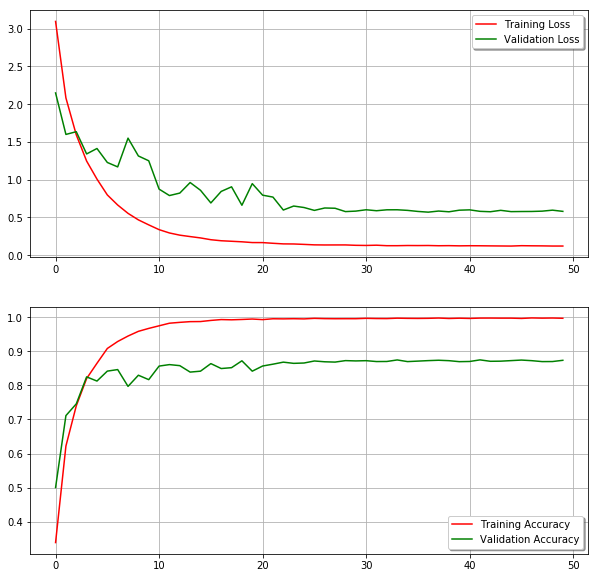

In [130]:
draw_result(history_se_3, "CNN_SENet+combine")

In [131]:
loss_combine, acc_combine = evaluate(se_model_3, x_test_3, y_test_3)
print(loss_combine, str(acc_combine*100)+"%")

4914/4914 [==============================] - 2s 415us/step
0.5880072064937302 87.09808708838345%


In [133]:
confusion_mat_combine = get_confusion_mat(se_model_3, x_test_3, y_test_3)
per_acc_combine = compute_per_acc(confusion_mat_combine, num_label_3)
print(per_acc_combine)

[('－', 1.0), ('÷', 1.0), ('＜', 1.0), ('Σ', 1.0), ('＠', 1.0), ('＃', 1.0), ('→', 0.9705882352941176), ('Ω', 0.9607843137254902), ('ｃ', 0.9607843137254902), ('＝', 0.9574468085106383), ('Π', 0.9574468085106383), ('Ｆ', 0.9558823529411765), ('ｗ', 0.9553571428571429), ('ｏ', 0.954954954954955), ('ｖ', 0.9541284403669725), ('⊕', 0.9523809523809523), ('Ｙ', 0.9516129032258065), ('）', 0.95), ('ｄ', 0.95), ('ｋ', 0.9465648854961832), ('≠', 0.9433962264150944), ('ｅ', 0.9423076923076923), ('ｐ', 0.9391304347826087), ('＋', 0.9361702127659575), ('＞', 0.9354838709677419), ('Ｔ', 0.9315068493150684), ('Ｌ', 0.9310344827586207), ('Ｎ', 0.9272727272727272), ('？', 0.926829268292683), ('Ｈ', 0.9230769230769231), ('Ｅ', 0.921875), ('Ｂ', 0.9215686274509803), ('￥', 0.9166666666666666), ('３', 0.9142857142857143), ('Ａ', 0.9122807017543859), ('ｓ', 0.9090909090909091), ('←', 0.9069767441860465), ('↓', 0.9024390243902439), ('ｂ', 0.9019607843137255), ('ｍ', 0.9), ('≥', 0.8974358974358975), ('θ', 0.8974358974358975), ('≤', 0.89

In [134]:
len(per_acc_combine)

86

In [156]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception 
from keras.applications.inception_v3 import InceptionV3

from keras.models import Model
from keras.utils import multi_gpu_model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,BatchNormalization
from keras.optimizers import SGD,RMSprop,Adadelta
from keras.layers import Conv2D, MaxPooling2D,Flatten


#使用MobileNetV2网络模型进行训练
base_model = MobileNetV2(weights="imagenet", include_top=False,pooling = 'avg')
output = base_model.output
predictions = Dense(64, activation='softmax')(output)

mobile_model_combine = Model(inputs=base_model.input, outputs=predictions)

C:\Users\lenovo\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [157]:
optimizer = RMSprop(lr = 0.001, decay=0.0)
mobile_model_combine.compile(optimizer=optimizer , loss='categorical_crossentropy', metrics=['accuracy'])
history_mob = mobile_model_combine.fit_generator(generator=get_train_batch(x_train, y_train, 128), steps_per_epoch=steps_train_epoch, 
          epochs=50,validation_data=get_train_batch(x_test, y_test, 128),validation_steps=steps_test_epoch, callbacks=[learning_rate_reduction])

Epoch 1/50
61/61 [==============================] - 13s 206ms/step - loss: 2.6946 - acc: 0.3677 - val_loss: 2.3671 - val_acc: 0.4772
Epoch 2/50
61/61 [==============================] - 5s 74ms/step - loss: 0.9647 - acc: 0.7295 - val_loss: 2.2120 - val_acc: 0.5970
Epoch 3/50
61/61 [==============================] - 4s 71ms/step - loss: 0.5908 - acc: 0.8294 - val_loss: 3.7208 - val_acc: 0.4883
Epoch 4/50
61/61 [==============================] - 4s 71ms/step - loss: 0.4490 - acc: 0.8691 - val_loss: 2.1291 - val_acc: 0.6867: 0.4463 - acc: 0.870
Epoch 5/50
61/61 [==============================] - 4s 70ms/step - loss: 0.3388 - acc: 0.9017 - val_loss: 2.2171 - val_acc: 0.6879
Epoch 6/50
61/61 [==============================] - 4s 71ms/step - loss: 0.3033 - acc: 0.9148 - val_loss: 3.0366 - val_acc: 0.6402
Epoch 7/50
61/61 [==============================] - 4s 71ms/step - loss: 0.2692 - acc: 0.9246 - val_loss: 3.5095 - val_acc: 0.5823
Epoch 8/50
61/61 [==============================] - 4s 71ms/

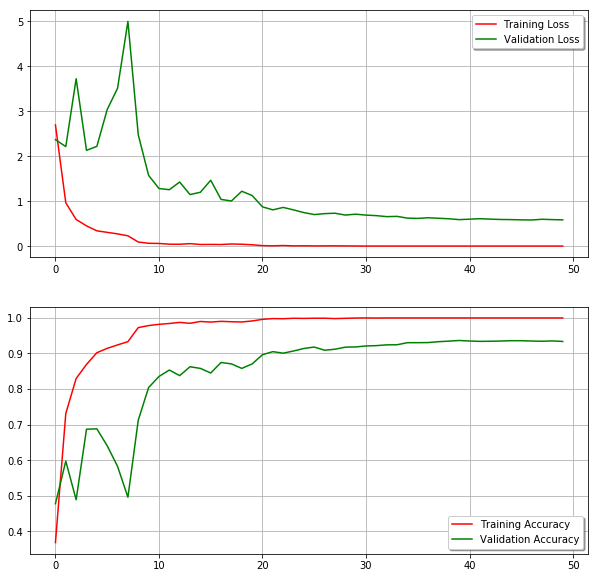

In [158]:
draw_result(history_mob, "mobile+combine")

In [160]:
loss_mob_combine, acc_mob_combine = evaluate(mobile_model_combine, x_test, y_test)
print(loss_mob_combine, str(acc_mob_combine*100)+"%")

3374/3374 [==============================] - 1s 340us/step
0.5866595646443765 93.39063426200356%


In [162]:
confusion_mat_mob_comnbine = get_confusion_mat(mobile_model_combine, x_test, y_test)
per_acc_mat_combine = compute_per_acc(confusion_mat_mob_comnbine, num2label)
print(per_acc_mat_combine)

[('←', 1.0), ('≤', 1.0), ('＋', 1.0), ('Ｎ', 1.0), ('Ｂ', 1.0), ('）', 1.0), ('＝', 1.0), ('⊕', 1.0), ('［', 1.0), ('－', 1.0), ('２', 1.0), ('４', 1.0), ('÷', 1.0), ('＃', 1.0), ('Ａ', 0.9841269841269841), ('Ｅ', 0.9827586206896551), ('３', 0.9824561403508771), ('ｉ', 0.9818181818181818), ('Ｄ', 0.9811320754716981), ('？', 0.975), ('＜', 0.9705882352941176), ('ｔ', 0.9701492537313433), ('Ｇ', 0.9696969696969697), ('↓', 0.96875), ('Ｙ', 0.96875), ('Ｒ', 0.96875), ('ｘ', 0.9661016949152542), ('ｄ', 0.9649122807017544), ('ｋ', 0.9642857142857143), ('７', 0.9629629629629629), ('Ｔ', 0.9622641509433962), ('ｅ', 0.958904109589041), ('→', 0.9574468085106383), ('↑', 0.9523809523809523), ('＞', 0.95), ('Ｉ', 0.9482758620689655), ('Ｈ', 0.9473684210526315), ('ｙ', 0.9454545454545454), ('Ｆ', 0.9420289855072463), ('ｓ', 0.9402985074626866), ('ｊ', 0.9393939393939394), ('ｎ', 0.9344262295081968), ('Ｑ', 0.9333333333333333), ('ｗ', 0.9272727272727272), ('ｕ', 0.9272727272727272), ('｝', 0.925), ('（', 0.925), ('１', 0.9107142857142857), 

In [164]:
mobile_model_combine.save("mobilenet_64.h5")

In [1]:
from keras.models import load_model
#加载模型的地址
model = load_model('mobilenet_64.h5')

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a prunned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    prunned so subgraphs that are not neccesary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [3]:
from keras import backend as K
import tensorflow as tf

frozen_graph = freeze_session(K.get_session(), output_names=[model.output.op.name])
tf.train.write_graph(frozen_graph, "model", "mobilenet_64.pb", as_text=False)

INFO:tensorflow:Froze 632 variables.
INFO:tensorflow:Converted 632 variables to const ops.


'model\\mobilenet_64.pb'